In [2]:
# carico i modelli dalla mia repository

def get_dbn_library():
  files = ["DBN.py"]
  repository_url = "https://raw.githubusercontent.com/LorenzoTausani/Octave_CPU/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

get_dbn_library()

import DBN

from torchvision import datasets,transforms
import torch
import matplotlib.pyplot as plt
import os
import pickle
import numpy as np
from matplotlib import cm

from DBN import DBN

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device {DEVICE}")

--2022-07-01 10:23:45--  https://raw.githubusercontent.com/LorenzoTausani/Octave_CPU/master/DBN.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11381 (11K) [text/plain]
Saving to: ‘DBN.py’

DBN.py              100%[===================>]  11.11K  --.-KB/s    in 0s      

2022-07-01 10:23:45 (90.8 MB/s) - ‘DBN.py’ saved [11381/11381]

Using device cpu


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw

The number shown is the number: 8


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


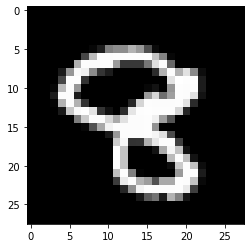

In [10]:
#Loading MNIST dataset
mnist_data_train = datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose(
                    [transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]))

mnist_data_test = datasets.MNIST('../data', train=False, download=True,
                    transform=transforms.Compose(
                    [transforms.ToTensor(),transforms.Normalize((0.1307,), (0.3081,))]))


mnist_data_train.data = (mnist_data_train.data.type(torch.FloatTensor)/255)
mnist_data_test.data = (mnist_data_test.data.type(torch.FloatTensor)/255)

#https://stackoverflow.com/questions/68056122/attributeerror-cant-set-attribute-in-splitting-mnist-dataset


#Lets us visualize a number from the data set
idx = 787
img = mnist_data_test.data[idx]
print("The number shown is the number: {}".format(mnist_data_test.train_labels[idx]) )
plt.imshow(img , cmap = 'gray')
plt.show()

train_data = mnist_data_train.data.to(DEVICE)
train_labels = mnist_data_train.train_labels.to(DEVICE)

test_data = mnist_data_test.data.to(DEVICE)
test_labels = mnist_data_test.train_labels.to(DEVICE)

#modificare solo se necessario
sample_test_data = test_data[:1000,:] 
sample_test_labels = test_labels[:1000]

In [11]:
def model_load_or_create(train_data, train_labels, sample_test_data, sample_test_labels):
  Load_yn=int(input('do you want to load an old model? (1=yes, 0=no)'))

  if Load_yn==1:
    nr_train_epochs_done=int(input('quante epoche di training della RBM?'))
    #h_train_size = int(input('quanti h train generati (0 se nessuno)?'))
    #h_test_size = int(input('quanti h test generati (0 se nessuno)?'))
    #nr_steps = int(input('con quanti step di ricostruzione?'))

    h_train_size = len(train_labels)
    h_test_size = len(sample_test_labels)
    nr_steps = 100

    filename = 'OctaveCPU_RBM'+ str(nr_train_epochs_done)+'_generated_h_train'+str(h_train_size)+'_generated_h_test'+str(h_test_size)+'nr_steps'+str(nr_steps)

    model = load_model(filename)

  else:
    num_epochs = int(input('trainare la rete? quante epoche? (0 se non si vuole trainare'))

    model = DBN(maxepochs   = num_epochs ,device=DEVICE)    
    model.train(train_data,train_labels)

  dati_generati_yn = int(input('creare nuovi dati generati (0=no, 1=train, 2=test, 3= entrambi)'))

  if dati_generati_yn ==1 or dati_generati_yn ==3:
    nr_steps = 1
    model.reconstruct(train_data,nr_steps,new_test1_train2_set = 2,lbl_train=train_labels)

  if dati_generati_yn ==2 or dati_generati_yn ==3:
    print('jodel')
    nr_steps = 100
    model.reconstruct(sample_test_data,nr_steps,new_test1_train2_set = 1,lbl_test=sample_test_labels)

  if not(hasattr(model, 'Cl_TEST_step_accuracy')):
    model.stepwise_Cl_accuracy()

  save_yn = int(input('salvare il modello? (0=no, 1=si)'))

  if save_yn ==1:
    model.save_model()

  return model  

def load_model(filename):

    filename = '/content/gdrive/My Drive/' + filename + '/' + filename + '.pkl'

    from google.colab import drive
    drive.mount('/content/gdrive')

    with open(filename, 'rb') as inp:
        model = pickle.load(inp)

    return model  


In [ ]:
#nr_models_to_compare = int(input('how many models do you want to compare?'))
nr_models_to_compare = 6
models_list =[]

for i in range(nr_models_to_compare):
  model = model_load_or_create(train_data, train_labels, sample_test_data, sample_test_labels)
  models_list.append(model)
  



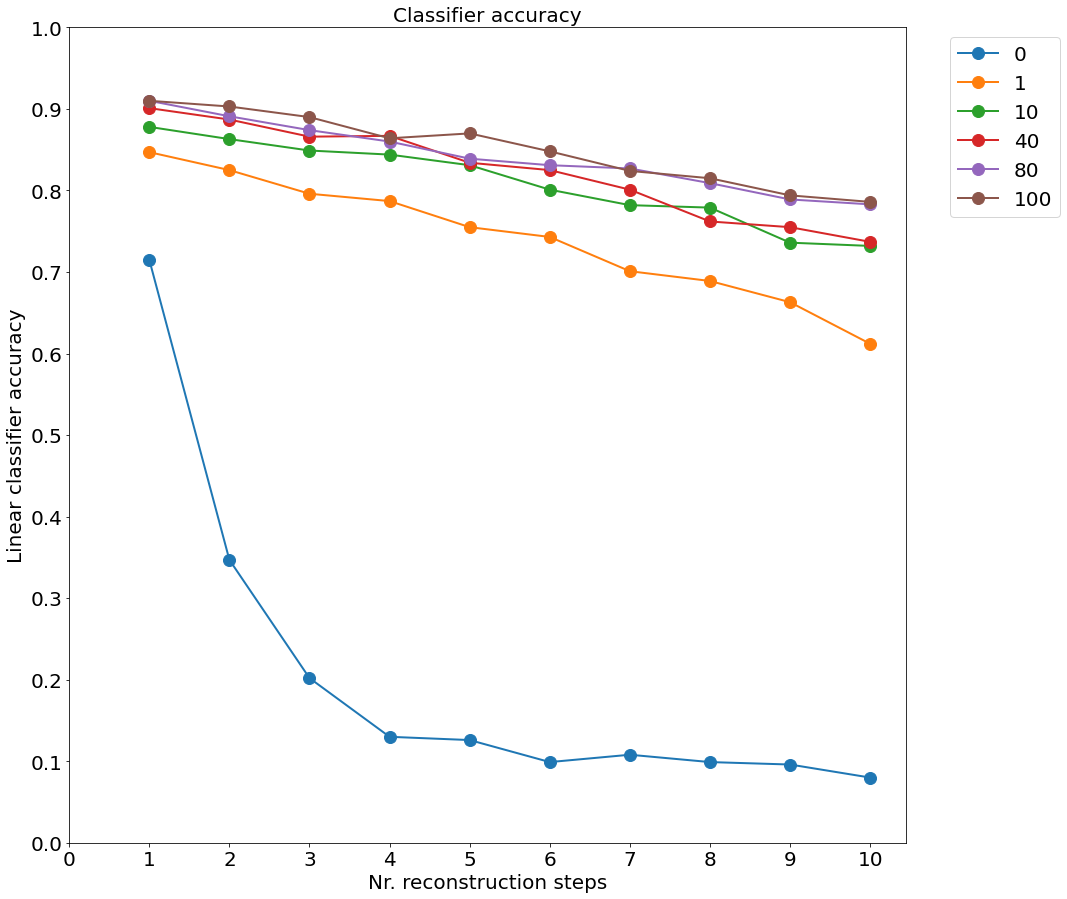

In [49]:
figure, axis = plt.subplots(1, 1, figsize=(15,15))

lbls = []
x = range(1,11)


c=0
cmap = cm.get_cmap('hsv')
for model in models_list:
  axis.plot(x,model.Cl_TEST_step_accuracy[:10], linewidth=3, markersize=12,marker='o', c=cmap(c/256))
  c = c+30
  lbls.append(model.maxepochs)

axis.tick_params(axis='x', labelsize= 20)
axis.tick_params(axis='y', labelsize= 20)

axis.legend(lbls, bbox_to_anchor=(1.04,1), loc="upper left", fontsize=20) #cambia posizione
axis.set_ylabel('Linear classifier accuracy',fontsize=20)
axis.set_xlabel('Nr. reconstruction steps',fontsize=20)
axis.set_title('Classifier accuracy',fontsize=20)

axis.set_xticks(np.arange(0, 11, 1))
axis.set_yticks(np.arange(0, 1.1, 0.1))


plt.show()
  


In [8]:
cmap = cm.get_cmap('hsv')

rgba = cmap(50/256)
print(rgba)

(0.8419106066164891, 1.0, 0.0, 1.0)
